# Linear Regression Model Analysis

#### Import Statements and Cleaned Dataset Loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
df_cleaned = pd.read_csv("./df_cleaned_new2.csv")

#### Data Splitting and Scaling

In [2]:
# defining the target (response) variable and features
target_column = 'SalePrice'
X = df_cleaned.drop(columns=[target_column])  # features (independent variables)
y = df_cleaned[target_column]  # target variable (dependent variable)

# 80% training, 20% testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline Linear Regression Model and Model Evaluation Metrics

In [3]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

yp_baseline_train = baseline_model.predict(X_train)
yp_baseline_test = baseline_model.predict(X_test)

#Training Data Metrics
r2_train_base = r2_score(y_train, yp_baseline_train)
mse_train_base = mean_squared_error(y_train, yp_baseline_train)

#Testing Data Metrics
r2_test_base = r2_score(y_test, yp_baseline_test)
mse_test_base = mean_squared_error(y_test, yp_baseline_test)

#printing metrics
print("Training Metrics:")
print(f"Training R²: {r2_train_base:.4f}")
print(f"Training MSE: {mse_train_base:.4f}")
print("Testing Metrics:")
print(f"Testing R²: {r2_test_base:.4f}")
print(f"Testing MSE: {mse_test_base:.4f}")


Training Metrics:
Training R²: 0.9039
Training MSE: 382753966.7287
Testing Metrics:
Testing R²: 0.8579
Testing MSE: 592341266.6793


#### Lasso Regression Model with GridSearch CV (Feature Selection and Parameter Tuning):

In [4]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False) #scoring function (MSE)
#parameter grid to test out different alpha values
param_grid = {
    'alpha': np.logspace(-3,3,50)
}

lasso=Lasso(max_iter=1000, random_state=42) #increased to ensure that it converges

#GridSearchCV:
lasso_cv = GridSearchCV(lasso, param_grid, scoring=mse_scorer, cv=5)
lasso_cv.fit(X_train, y_train)

#best params and performance (MSE) from CV
best_lasso = lasso_cv.best_estimator_
best_lasso_alpha = lasso_cv.best_params_['alpha']
print("Best Alpha: ", best_lasso_alpha)
print("Best MSE: ", lasso_cv.best_score_)

#test set evaluation
yp_lasso = best_lasso.predict(X_test)
test_mse_lasso = mean_squared_error(y_test, yp_lasso)
print("Lasso Test MSE: ", test_mse_lasso)

#feature selection - all features with non-zero coefficients
selected_features=X_train.columns[best_lasso.coef_!=0]
print("Number of selected features: ", len(selected_features))
print("Selected features: ", selected_features.tolist())

Best Alpha:  323.745754281764
Best MSE:  -485924122.3984102
Lasso Test MSE:  508158129.03752047
Number of selected features:  33
Selected features:  ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'HouseAge', 'TotalBathrooms', 'RoomAreaRatio', 'HeatingQC_Ex', 'GarageFinish_RFn']


#### Ridge Regression Model (Feature Selection and Parameter Tuning using RFE)

In [5]:
from sklearn.feature_selection import RFECV

#Ridge Model with Recursive Feature Elimination as there is no Feature Selection in Ridge
# (ie. using RFE for feature selection based on feature importance):
ridge=Ridge(random_state=42)
ridge_rfecv = RFECV(estimator=ridge, step=1, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
ridge_rfecv.fit(X_train, y_train)

#feature selection from RFE
selected_feat_ridge = X_train.columns[ridge_rfecv.support_]
print("Number of selected features: ", len(selected_feat_ridge))
print("Selected features: ", selected_feat_ridge.tolist())

#based on selected features (filtering for features selected through RFE)
X_train_rfe = X_train[selected_feat_ridge]
X_test_rfe = X_test[selected_feat_ridge]

ridge_params = {'alpha': np.logspace(-3, 3, 50)}  #testing different alpha values for grid search CV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge_cv = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring=mse_scorer, cv=5, n_jobs=-1)
ridge_cv.fit(X_train_rfe, y_train)

#best alpha and CV MSE
best_ridge_alpha = ridge_cv.best_params_['alpha']
best_ridge_mse = -ridge_cv.best_score_

print("Best Ridge Alpha: ", best_ridge_alpha)
print("Best Ridge CV MSE: ", best_ridge_mse)

#test set metrics
ridge_best = Ridge(alpha=best_ridge_alpha, random_state=42)
ridge_best.fit(X_train_rfe, y_train)
ridge_test_mse = mean_squared_error(y_test, ridge_best.predict(X_test_rfe))
ridge_test_r2 = ridge_best.score(X_test_rfe, y_test)
print(f"Ridge Test MSE: {ridge_test_mse}")
print(f"Ridge Test R²: {ridge_test_r2}")

Number of selected features:  184
Selected features:  ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'HouseAge', 'TotalBathrooms', 'RoomAreaRatio', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDO

#### Model Metric Evaluation Table

In [6]:
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Number of Params
p_base = X_train.shape[1] #all features used
p_ridge = len(selected_feat_ridge)
p_lasso = len(selected_features)

#Quantifying "n" for both sets
n_train = X_train.shape[0]
n_test = X_test.shape[0]

#metrics for baseline linear model
baseline_train_mse = mse_train_base
baseline_test_mse = mse_test_base
baseline_train_r2 = r2_train_base
baseline_test_r2 = r2_test_base
baseline_adj_r2_train = adjusted_r2(r2_train_base, n_train, p_base)
baseline_adj_r2_test = adjusted_r2(r2_test_base, n_test, p_base)

#metrics for ridge:
ridge_train_mse = mean_squared_error(y_train, ridge_best.predict(X_train_rfe))
ridge_train_r2 = ridge_best.score(X_train_rfe, y_train)
ridge_test_mse = mean_squared_error(y_test, ridge_best.predict(X_test_rfe))
ridge_test_r2 = ridge_best.score(X_test_rfe, y_test)
ridge_cv_mse = best_ridge_mse
ridge_adj_r2_train = adjusted_r2(ridge_train_r2, n_train, p_ridge)
ridge_adj_r2_test = adjusted_r2(ridge_test_r2, n_test, p_ridge)

#metrics for lasso:
lasso_train_mse = mean_squared_error(y_train, best_lasso.predict(X_train))
lasso_train_r2 = best_lasso.score(X_train, y_train)
lasso_test_mse = mean_squared_error(y_test, best_lasso.predict(X_test))
lasso_test_r2 = best_lasso.score(X_test, y_test)
lasso_cv_mse = -lasso_cv.best_score_
lasso_adj_r2_train = adjusted_r2(lasso_train_r2, n_train, p_lasso)
lasso_adj_r2_test = adjusted_r2(lasso_test_r2, n_test, p_lasso)

reg_metrics_df = pd.DataFrame({
    "Model": ["Baseline Linear", "Ridge Regression", "Lasso Regression"],
    "Train MSE": [baseline_train_mse, ridge_train_mse, lasso_train_mse],
    "Test MSE": [baseline_test_mse, ridge_test_mse, lasso_test_mse],
    "Train R²": [baseline_train_r2, ridge_train_r2, lasso_train_r2],
    "Test R²": [baseline_test_r2, ridge_test_r2, lasso_test_r2],
    "CV MSE": ['N/A', ridge_cv_mse, lasso_cv_mse],
})

print(reg_metrics_df)


              Model     Train MSE      Test MSE  Train R²   Test R²  \
0   Baseline Linear  3.827540e+08  5.923413e+08  0.903870  0.857917   
1  Ridge Regression  4.127966e+08  5.130923e+08  0.896325  0.876927   
2  Lasso Regression  4.298156e+08  5.081581e+08  0.892051  0.878110   

             CV MSE  
0               N/A  
1  517996451.110735  
2   485924122.39841  


#### Visualizations of Model Performance:

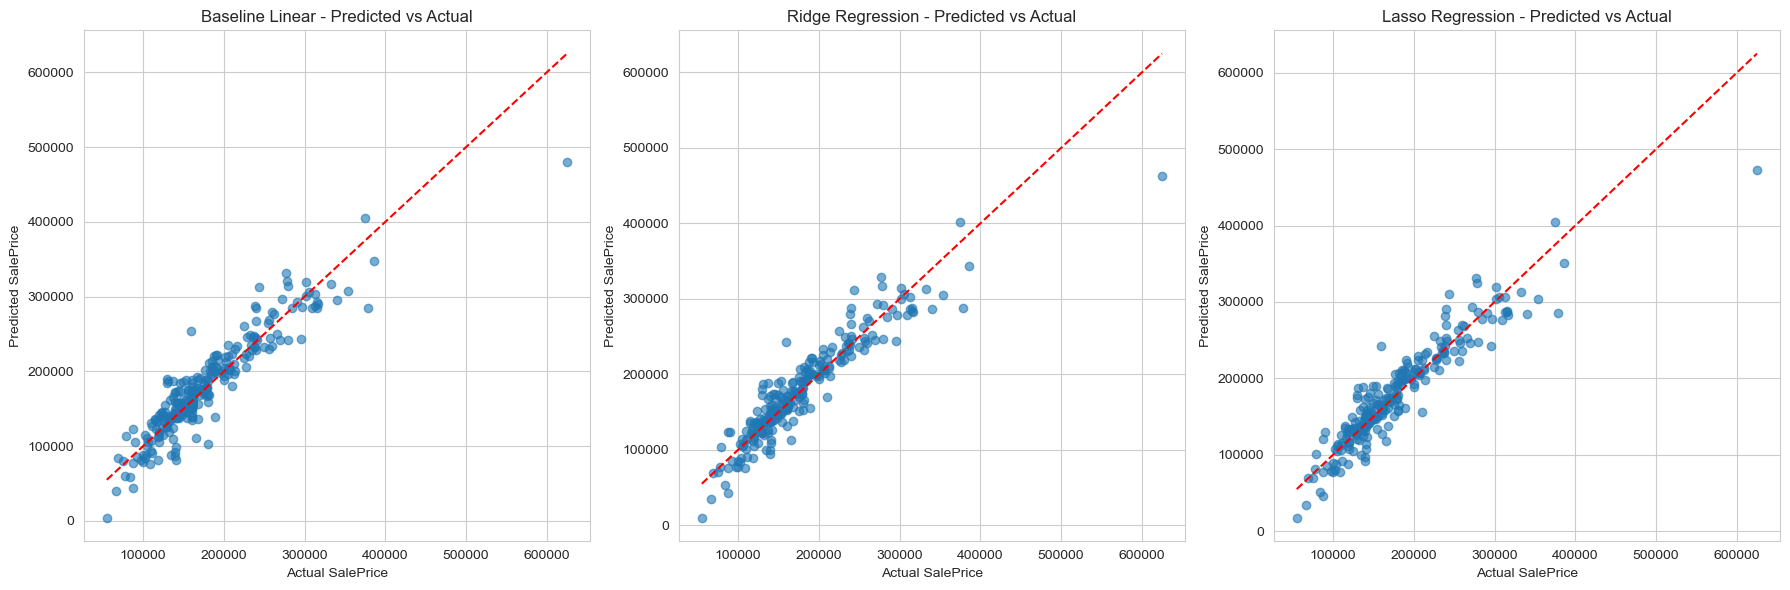

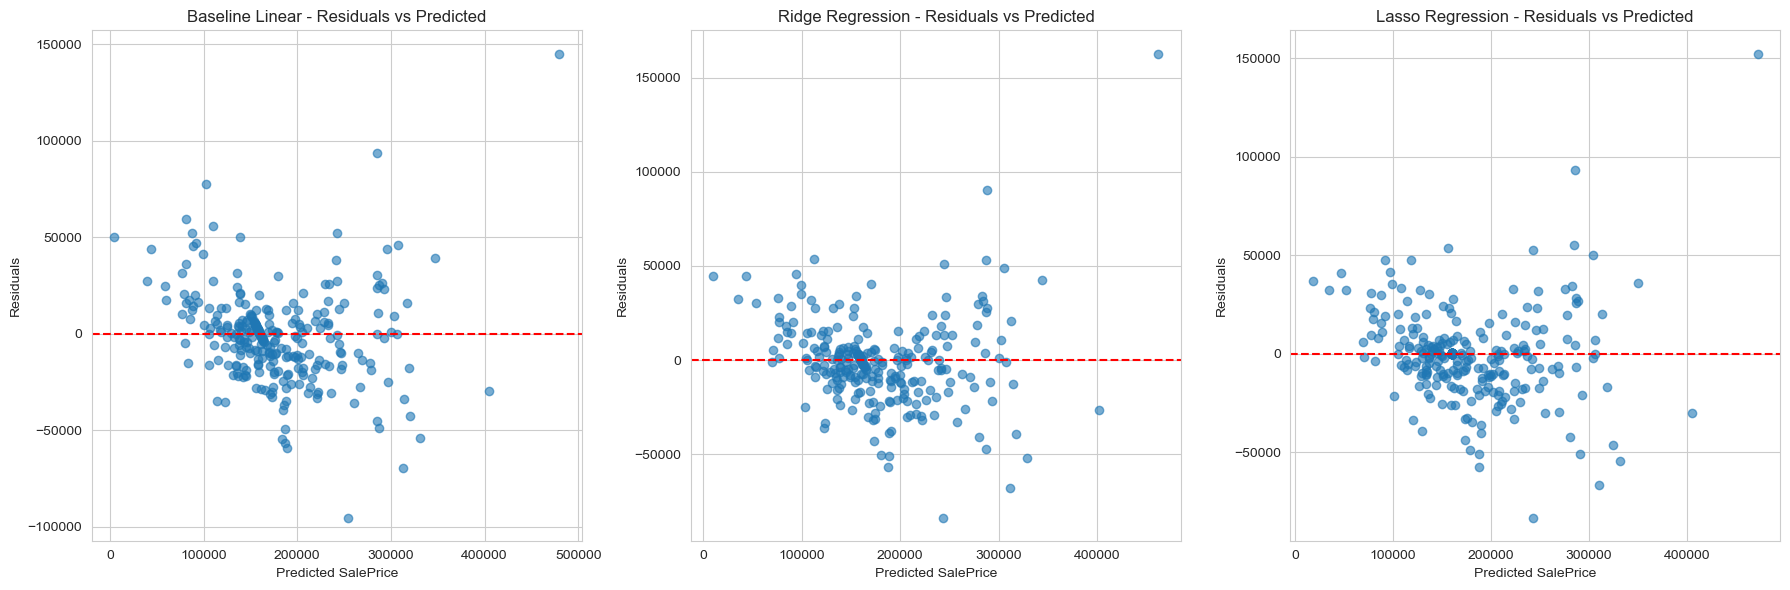

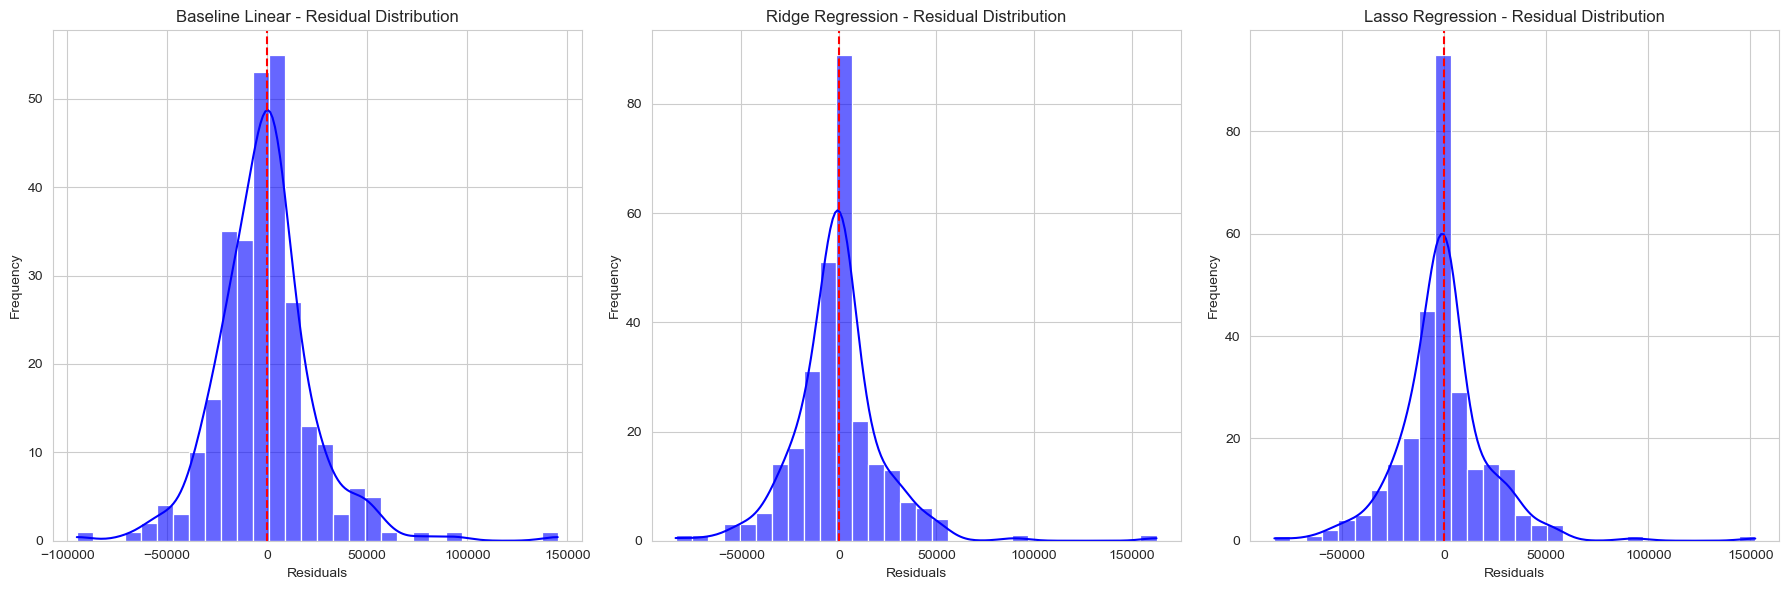

In [7]:
# plot 1 - actual vs predicted scatter
plt.figure(figsize=(18, 6))

# baseline
plt.subplot(1, 3, 1)
plt.scatter(y_test, yp_baseline_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Baseline Linear - Predicted vs Actual')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')

# ridge
plt.subplot(1, 3, 2)
yp_ridge = ridge_best.predict(X_test_rfe)
plt.scatter(y_test, yp_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Ridge Regression - Predicted vs Actual')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')

# lasso
plt.subplot(1, 3, 3)
yp_lasso = best_lasso.predict(X_test)
plt.scatter(y_test, yp_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Lasso Regression - Predicted vs Actual')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')

plt.tight_layout()
plt.show()

# plot 2 - Residuals vs Predicted
plt.figure(figsize=(18, 6))

# base
plt.subplot(1, 3, 1)
residuals_baseline = y_test - yp_baseline_test
plt.scatter(yp_baseline_test, residuals_baseline, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Baseline Linear - Residuals vs Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')

# ridge
plt.subplot(1, 3, 2)
residuals_ridge = y_test - yp_ridge
plt.scatter(yp_ridge, residuals_ridge, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Ridge Regression - Residuals vs Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')

# lasso
plt.subplot(1, 3, 3)
residuals_lasso = y_test - yp_lasso
plt.scatter(yp_lasso, residuals_lasso, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Lasso Regression - Residuals vs Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# plot 3 - residual histogram
plt.figure(figsize=(18, 6))

# base
plt.subplot(1, 3, 1)
sns.histplot(residuals_baseline, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title('Baseline Linear - Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# ridge
plt.subplot(1, 3, 2)
sns.histplot(residuals_ridge, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title('Ridge Regression - Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# lasso
plt.subplot(1, 3, 3)
sns.histplot(residuals_lasso, kde=True, bins=30, color='blue', alpha=0.6)
plt.axvline(0, color='red', linestyle='--')
plt.title('Lasso Regression - Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Final Linear Regression Model - Lasso:

In [8]:
best_lasso.fit(X_train, y_train)

lasso_model_params = {
    "alpha": best_lasso.alpha,
    "coefficients": best_lasso.coef_,  # Feature coefficients
    "intercept": best_lasso.intercept_,  # Intercept term
    "selected_features": X_train.columns[best_lasso.coef_ != 0].tolist(),  # Non-zero coefficient features
}
print("Lasso Parameters: ")
for key, value in lasso_model_params.items():
    print(f"{key}: {value}")

Lasso Parameters: 
alpha: 323.745754281764
coefficients: [-9.52724635e+01  6.77426963e-01  1.43987562e+04  6.15814155e+03
  2.03541880e+02  1.70376552e+02  8.26563669e+00 -7.54772930e+00
 -1.36319219e+01  3.46185823e+01  3.32874984e+01  3.42707680e+01
 -2.69099693e+00  1.05295353e+02  0.00000000e+00  0.00000000e+00
 -8.89423301e+02  0.00000000e+00 -9.58635942e+03 -0.00000000e+00
 -1.61585869e+04  1.18363456e+03  1.18245066e+03  2.05743304e+01
  8.87069499e+00  1.80914362e+01  3.24441432e+01 -3.07111667e+01
  5.26983817e+01 -2.22424875e+01 -2.13931100e+00 -4.94822209e+02
 -0.00000000e+00 -2.22647402e+02 -1.09725482e+03 -4.69152507e+02
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 

In [9]:
lasso_model_params = {
    "alpha": best_lasso.alpha,
    "coefficients": best_lasso.coef_,
    "intercept": best_lasso.intercept_,
}

non_zero_features = [(feature, coef) for feature, coef in zip(X_train.columns, lasso_model_params['coefficients']) if coef != 0]
non_zero_features_sorted = sorted(non_zero_features, key=lambda x: abs(x[1]), reverse=True)
print("Lasso Non-Zero Coefficients (Sorted by Absolute Value):")
for feature, coef in non_zero_features_sorted:
    print(f"{feature}: {coef}")

Lasso Non-Zero Coefficients (Sorted by Absolute Value):
TotRmsAbvGrd: -16158.586922352988
OverallQual: 14398.756235448169
BedroomAbvGr: -9586.359415932027
OverallCond: 6158.141554402644
Fireplaces: 1183.6345596548604
GarageCars: 1182.4506608451288
TotalBathrooms: -1097.2548154935719
FullBath: -889.4233010233316
MoSold: -494.8222090292157
RoomAreaRatio: -469.15250733688083
HeatingQC_Ex: 444.77932685650245
HouseAge: -222.6474019853579
YearBuilt: 203.5418804694048
YearRemodAdd: 170.37655156993696
GarageFinish_RFn: 165.61613849212148
GrLivArea: 105.29535291491233
MSSubClass: -95.27246347550384
ScreenPorch: 52.6983817353893
TotalBsmtSF: 34.618582281159
2ndFlrSF: 34.270767963018955
1stFlrSF: 33.28749841390478
EnclosedPorch: 32.444143211008125
3SsnPorch: -30.71116667658941
PoolArea: -22.242487530621386
GarageArea: 20.574330431684235
OpenPorchSF: 18.091436236422847
BsmtUnfSF: -13.63192189792069
WoodDeckSF: 8.870694993092261
BsmtFinSF1: 8.265636688561848
BsmtFinSF2: -7.547729297649637
LowQualFi

#### Final Regression Model (Lasso) Visualizations

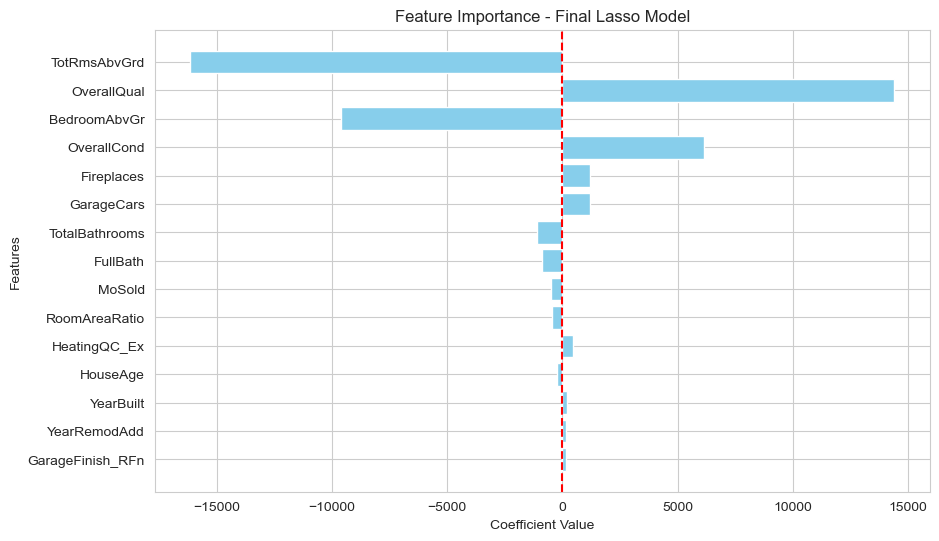

In [10]:
# lasso
non_zero_features = X_train.columns[best_lasso.coef_ != 0]
non_zero_coefficients = best_lasso.coef_[best_lasso.coef_ != 0]
feature_importance = pd.DataFrame({
    "Feature": non_zero_features,
    "Coefficient": non_zero_coefficients
})
lasso_feature_importance = feature_importance.reindex(feature_importance["Coefficient"].abs().sort_values(ascending=False).index).head(15)
plt.figure(figsize=(10, 6))
plt.barh(lasso_feature_importance["Feature"], lasso_feature_importance["Coefficient"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")  # Mark the zero line for positive/negative separation
plt.title("Feature Importance - Final Lasso Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Aligns the most important features at the top
plt.show()


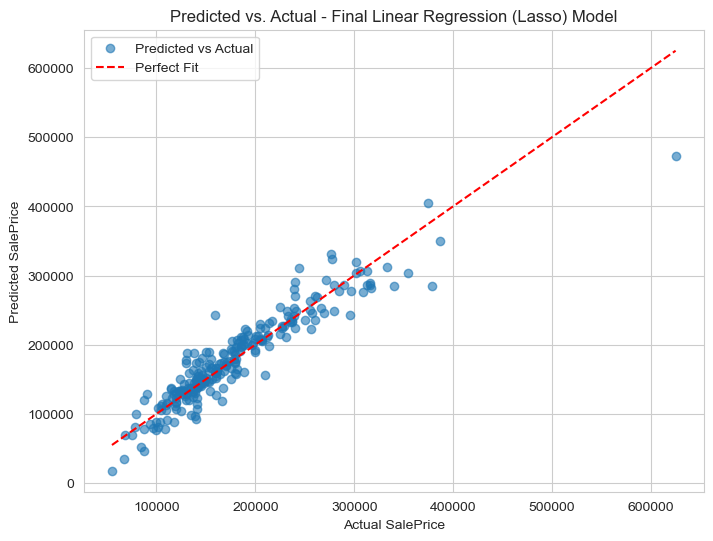

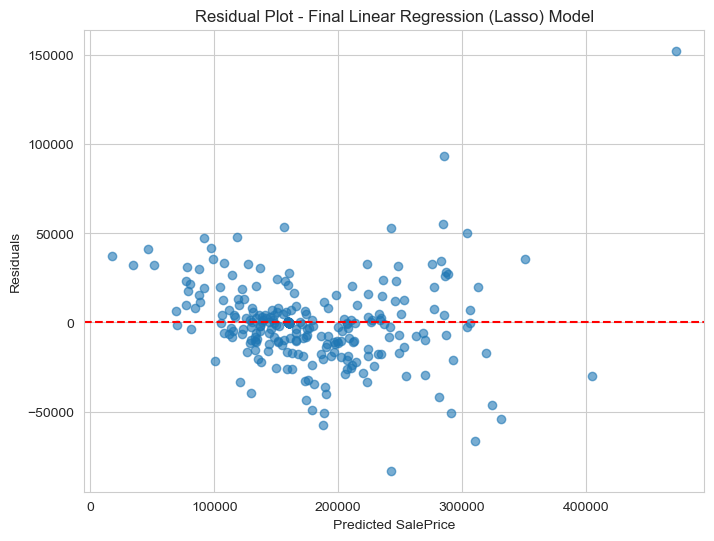

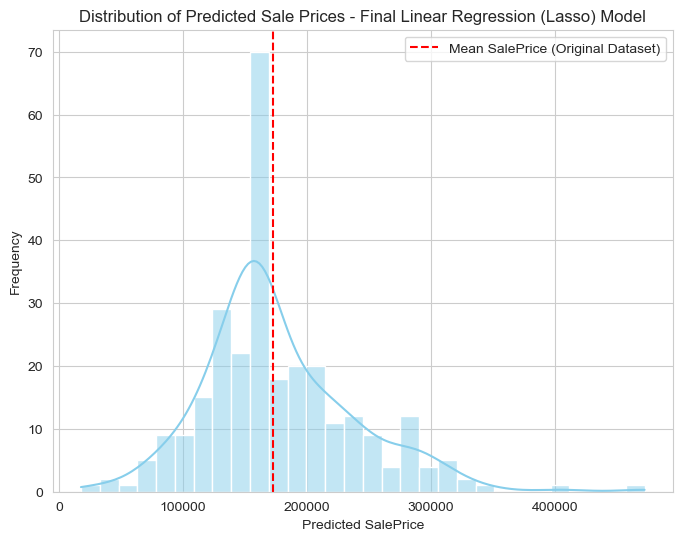

In [11]:
# pred vs actual values
y_pred_lasso = best_lasso.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.6, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title("Predicted vs. Actual - Final Linear Regression (Lasso) Model")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.legend()
plt.show()

# residuals vs predicted
residuals_lasso = y_test - y_pred_lasso
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Final Linear Regression (Lasso) Model")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.show()

# histogram of predictions
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_lasso, bins=30, kde=True, color="skyblue")
plt.title("Distribution of Predicted Sale Prices - Final Linear Regression (Lasso) Model")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Frequency")
plt.axvline(df_cleaned['SalePrice'].mean(), color='red', linestyle='--', label='Mean SalePrice (Original Dataset)')
plt.legend()
plt.show()